**Реализация модели Курамото**

Брылёва Екатерина
МБД 191


 **1.Модель Курамото**

---



In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy 
from scipy.signal import welch
from colorsys import hls_to_rgb
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt

1. Необходимо реализовать модель Курамото, состоящию из 500 осцилляторов, где частота задается равномерными значениями в пределах [frequency * 0.75; frequency * 1.25].

In [54]:
class Kuramoto:
    def __init__(self, t_k = 60, d_t = 0.01, K = 1.5, N = 500, sigma = 1, freq = 10, simulation_type = "first"):
        self.K = K #параметр самосинхронии
        self.N = N
        self.d_t = d_t
        self.sigma = sigma
        self.T = np.arange(0, t_k, d_t)
        self.N_times = len(self.T) 
        self.initial = np.random.uniform(-np.pi, np.pi, size = self.N)
     
        if simulation_type=="second":
            self.W = self.w_second
        elif simulation_type=="first":
            self.W = lambda t: np.random.uniform(0.75*freq, 1.25*freq, size=self.N)
        else:
            raise Error 

    #условия для второй симуляции:          
                
    def w_second(self, t):      
        w_frequency = [np.random.uniform(0.75 * fr, 1.25 * fr, size = self.N) for fr in [10, 20, 25, 10]]
        return w_frequency[0] * (0 < t <= 15) + w_frequency[1] * (15 < t <= 30) + w_frequency[2] * (30 < t <= 45) + w_frequency[3] * (45 < t <= 60)
    
    #фаза осциллятора(theta):

    def phase(self):      
        phase = np.zeros((self.N_times, self.N))
        phase[0, :] = self.initial    
        for i, j in list(enumerate(self.T))[1:]:          
            delta = np.sin(deepcopy(phase[i-1, :]) - phase[i-1, :][np.newaxis, :])
            phase[i, :] = phase[i-1, :] + (2 * np.pi * self.W(j) + self.K / self.N * np.sum(delta, axis=1) + np.random.normal(0, self.sigma)) * self.d_t     
        return phase
    
    
    def signal_result(self):
        phase = self.phase()
        phase_signal = np.mean(phase, axis = 1)
        res_signal = np.real(np.exp(1j*phase_signal))
        res_freq, psd = welch(res_signal, fs=1/self.d_t, scaling="spectrum")
        return res_signal, res_freq, psd

In [55]:
#Функция, возвращающая значения сигналов, частоты симуляций и PSD:
def values(input):
    f, simulation_type = input
    model = Kuramoto(freq = f, simulation_type = simulation_type)
    res_signal, res_freq, psd = model.signal_result()
    return res_signal, res_freq, psd

2. Используя соответственно параметризованные модели, необходимо симулировать 20 сигналов: 10 с частотой 10Гц, 5 с частотой 15Гц и 5 с частотой 25Гц.

In [57]:
res_freq = [10] * 10 + [15] * 5 + [25] * 5
with Parallel(cpu_count()) as pool:
    first_simulation = pool(delayed(values)((f, "first")) for f in tqdm(res_freq, leave=False))



  0%|          | 0/20 [00:00<?, ?it/s]

 20%|██        | 4/20 [00:00<00:02,  6.67it/s]

 30%|███       | 6/20 [00:01<00:02,  5.19it/s]

 40%|████      | 8/20 [00:01<00:02,  4.43it/s]

 50%|█████     | 10/20 [00:02<00:02,  4.00it/s]

 60%|██████    | 12/20 [00:03<00:02,  3.77it/s]

 70%|███████   | 14/20 [00:03<00:01,  3.52it/s]

 80%|████████  | 16/20 [00:04<00:01,  3.42it/s]

 90%|█████████ | 18/20 [00:04<00:00,  3.38it/s]

100%|██████████| 20/20 [00:05<00:00,  3.34it/s]

                                               

3. Используя соответственно параметризованные модели, необходимо симулировать сигнал с частотой 10Гц в промежутке 0-15 секунд, 20Гц в промежутке 15-30 секунд, 25Гц в 30-45 секунд и 10Гц в промежутке 45-60 секунд. Для получения устойчивых оценок, просимулируйте сигнал несколько раз. Например, возьмем 70 раз.

In [58]:
N_simulations = 70
with Parallel(cpu_count()) as pool:
    second_simulation = pool(delayed(values)((10, "second")) for f in tqdm(range(N_simulations), leave=False))



  0%|          | 0/70 [00:00<?, ?it/s]

  6%|▌         | 4/70 [00:01<00:19,  3.33it/s]

  9%|▊         | 6/70 [00:02<00:24,  2.58it/s]

 11%|█▏        | 8/70 [00:03<00:27,  2.24it/s]

 14%|█▍        | 10/70 [00:04<00:29,  2.06it/s]

 17%|█▋        | 12/70 [00:05<00:30,  1.93it/s]

 20%|██        | 14/70 [00:07<00:30,  1.86it/s]

 23%|██▎       | 16/70 [00:08<00:30,  1.79it/s]

 26%|██▌       | 18/70 [00:09<00:29,  1.76it/s]

 29%|██▊       | 20/70 [00:10<00:28,  1.74it/s]

 31%|███▏      | 22/70 [00:11<00:27,  1.73it/s]

 34%|███▍      | 24/70 [00:12<00:26,  1.73it/s]

 37%|███▋      | 26/70 [00:14<00:25,  1.72it/s]

 40%|████      | 28/70 [00:15<00:24,  1.71it/s]

 43%|████▎     | 30/70 [00:16<00:23,  1.70it/s]

 46%|████▌     | 32/70 [00:17<00:22,  1.71it/s]

 49%|████▊     | 34/70 [00:18<00:21,  1.71it/s]

 51%|█████▏    | 36/70 [00:20<00:20,  1.70it/s]

 54%|█████▍    | 38/70 [00:21<00:18,  1.69it/s]

 57%|█████▋    | 40/70 [00:22<00:17,  1.69it/s]

 60%|██████    | 42/70 [00:23<

**2. Анализ**

---



1. Посчитайте и нарисуйте Power Spectrum Density для обоих сигналов. 

In [66]:
def plot_psd(res_freq, res_psd, fs=16):
    plt.figure(figsize=(10, 5))
    plt.semilogy(res_freq, res_psd)
    plt.title('PSD')
    plt.xlabel('Frequency')
    plt.ylabel('PSD')

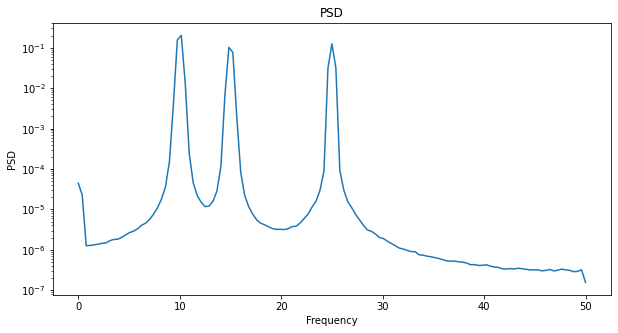

In [67]:
#Симуляция_1.2
plot_psd(np.mean([x[1] for x in first_simulation], axis=0), np.mean([x[2] for x in first_simulation], axis=0))    

Вывод: на графике видны три пика подачи сигналов на частотах 10,15 и 25.

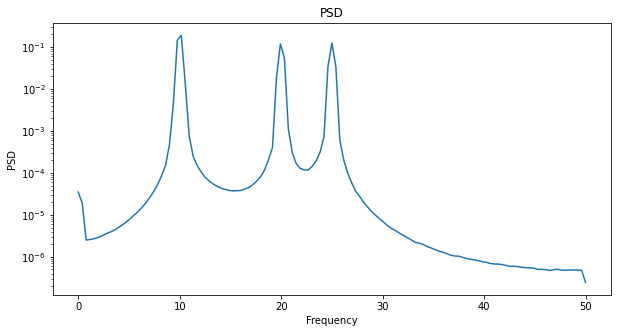

In [65]:
#Симуляция_1.3
plot_psd(np.mean([x[1] for x in second_simulation], axis=0), np.mean([x[2] for x in second_simulation], axis=0))    

Вывод: на графике также видны три пика подачи сигналов на частотах 10,15 и 25.

2. Посчитайте фазовую синхронию полученных сигналов, используя PLV.

In [70]:
def phases_syn(info):
    f, simulation_type = info
    model = Kuramoto(freq = f, simulation_type = simulation_type)
    phases_syn = model.phase()
    return phases_syn

In [72]:
with Parallel(cpu_count()) as pool:
    res_phase = pool(delayed(phases_syn)((f, "first")) for f in tqdm(res_freq, leave=False))




  0%|          | 0/20 [00:00<?, ?it/s]


 20%|██        | 4/20 [00:00<00:03,  4.72it/s]


 30%|███       | 6/20 [00:01<00:03,  3.98it/s]


 40%|████      | 8/20 [00:02<00:03,  3.52it/s]


 50%|█████     | 10/20 [00:03<00:03,  3.18it/s]


 60%|██████    | 12/20 [00:03<00:02,  2.97it/s]


 70%|███████   | 14/20 [00:04<00:02,  2.89it/s]


 80%|████████  | 16/20 [00:05<00:01,  2.89it/s]


 90%|█████████ | 18/20 [00:06<00:00,  2.78it/s]


100%|██████████| 20/20 [00:06<00:00,  2.74it/s]


                                               

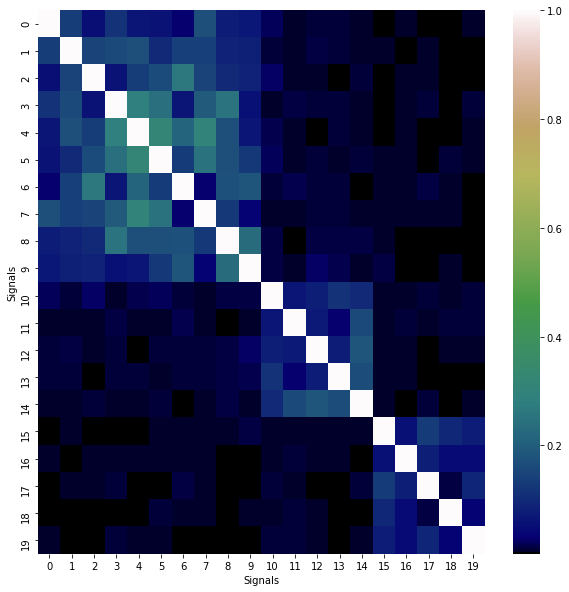

In [83]:
x = np.exp(1j * np.stack(res_phase, axis=0))
x = np.mean(x, axis=-1)
y = np.conj(x)
x /= np.abs(x)
y /= np.abs(y)
phases = np.abs((x @ y.T) / x.shape[1])

fig_phases = plt.figure(figsize=(10, 10))
ax = fig_phases.add_subplot(1, 1, 1)
sns.heatmap(phases, cmap = 'gist_earth', ax=ax)
ax.set_xlabel('Signals')
ax.set_ylabel('Signals')
plt.show()

Вывод: судя по трем квадратам разной цветовой гаммы, можно сделать вывод о том, что сигналы каждой частоты соответствуют каждому квадрату. Квадрат 10 на 10 включает 10 сигналов с чатотой 10Гц, два квадрата 5 на 5 соответствуют 5 сигналам с частотой 15Гц и 5 сигналам с частотой 25Гц. Так как эти квадраты ярче, чем другие области, значит, фазы сигналов с одинаковой частотой в каждом квадрате более схожи и имеют меньшую разницу. чем фазы сигналов с разными частотами.

3. Для данных из задания 1.3 посчитайте PSD по времени. Для этого побейте сигнал на окна равной длины, посчитайте PSD в них и отобразите как heatmap.

(0.0, 60.0)

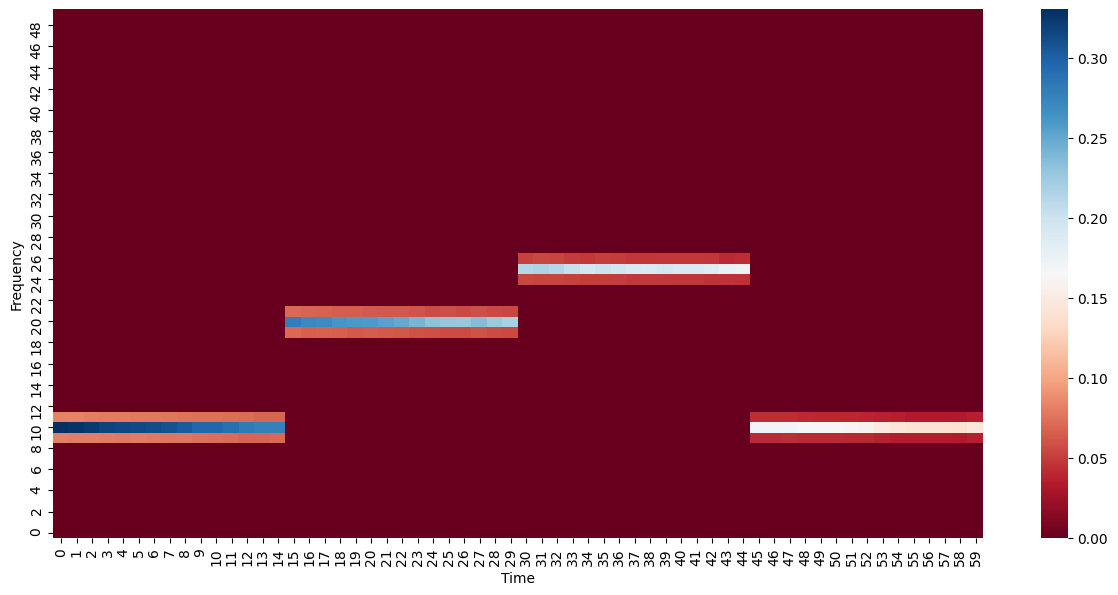

In [102]:
signal_PSD = np.mean([x[0] for x in second_simulation], axis=0)
split_signal = np.split(signal_PSD, len(signal)/50) #разбиваем 
hmap = np.array([welch(i, fs=int(1/0.01), nperseg=len(i))[1] for i in split]).T

plt.figure(figsize=(15, 7), dpi=100)
sns.heatmap(hmap, cmap="RdBu")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.ylim(0,50)
plt.xlim(0,60)

Вывод: На данном heatmap изображении второй симуляции видно, в каком порядке подавались сигналы. По горизонтали наблюдаем продолжительность сигнала, по вертикали частоту.

**3. Результат**

---



Выводы представлены под каждым графиком.